# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate


N_INDIVIDUALS = 10_000
N_INFECTIOUS = 100
N_PERIODS = 200

At first, we are loading some pre-defined parameters.

In [2]:
params = pd.read_csv("../../../sid/params.csv", index_col=["category", "name"])

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [3]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=N_INDIVIDUALS,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=N_INDIVIDUALS)

initial_states = pd.DataFrame({"age_group": age_group, "region": region}).astype("category")
initial_states.head(5)

,age_group,region
0,40 - 49,Gelderland
1,60 - 69,Gelderland
2,10 - 19,Drenthe
3,50 - 59,Gelderland
4,40 - 49,Drenthe


For the simulation, we need at least one individual which is infected.

In [4]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(N_INFECTIOUS, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [5]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)


contact_models = {
    "distant": {
        "model": meet_distant,
        "assort_by": ["age_group", "region"],
    },
    "close": {
        "model": meet_close,
        "assort_by": ["age_group", "region"],
    },
}

Sid allows to estimate one infection probability per contact type. In this example,
close contacts are more infectious as distant contacts with 5% versus 3%. At last,
drop a generic infection rate.

In [6]:
params.loc[("infection_prob", "close"), "value"] = 0.05
params.loc[("infection_prob", "distant"), "value"] = 0.03
params.drop(index=("infection_prob", "standard"), inplace=True)

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [7]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1

contact_policies = {
    "close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [8]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": N_PERIODS},
    contact_policies=contact_policies,
    seed=0,
)

The return of `simulate()` is a Dask DataFrame which loads the data lazily from disk. The following cell converts it to a pandas DataFrame, but keep in mind that the whole DataFrame has to fit into your memory.

In [9]:
df = df.compute()

In [10]:
df.head(5)

,index,age_group,region,ever_infected,immune,infectious,knows,symptoms,needs_icu,dead,cd_infectious_false,infection_counter,date,period,missed_close,missed_distant,close,distant,infections
0,0,40 - 49,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
1,1,60 - 69,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
2,2,10 - 19,Drenthe,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
3,3,50 - 59,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
4,4,40 - 49,Drenthe,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False


Let us take a look at various statistics of the sample.

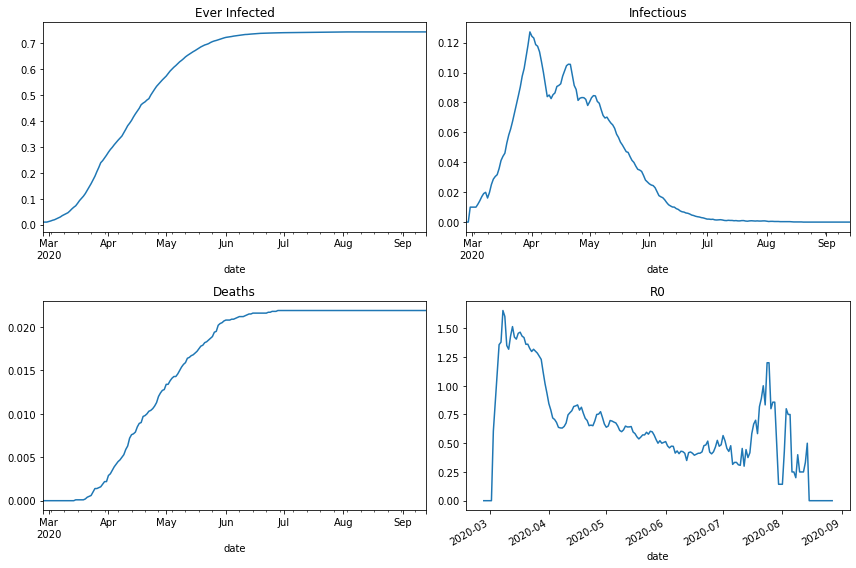

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("date").ever_infected.mean().plot(ax=axs[0])
df.groupby("date").infectious.mean().plot(ax=axs[1])
df.groupby("date").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("date").infection_counter.mean().plot(ax=axs[3])

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")

fig.tight_layout()

In [19]:
df.cd_infectious_false.max()

8.0

In [12]:
from sid.visualize_simulation_results import visualize_simulation_results

In [13]:
visualize_simulation_results(df, "./figures", ["close", "distant"], ["age_group", "region"], 7)

C:\tools\miniconda3\envs\sid\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\tools\miniconda3\envs\sid\lib\site-packages\numpy\lib\nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
C:\tools\miniconda3\envs\sid\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\tools\miniconda3\envs\sid\lib\site-packages\numpy\lib\nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [14]:
df

,index,age_group,region,ever_infected,immune,infectious,knows,symptoms,needs_icu,dead,cd_infectious_false,infection_counter,date,period,missed_close,missed_distant,close,distant,infections
0,0,40 - 49,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
1,1,60 - 69,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
2,2,10 - 19,Drenthe,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
3,3,50 - 59,Gelderland,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
4,4,40 - 49,Drenthe,False,False,False,False,False,False,False,-3.0,0,2020-02-27,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,80 - 100,Overtjssel,True,True,False,False,False,False,False,-158.0,1,2020-09-13,199,0,0,0,0,False
9996,9996,40 - 49,Overtjssel,False,False,False,False,False,False,False,-202.0,0,2020-09-13,199,0,0,0,0,False
9997,9997,80 - 100,Overtjssel,True,True,False,False,False,False,False,-150.0,2,2020-09-13,199,0,0,0,0,False
9998,9998,60 - 69,Overtjssel,True,True,False,False,False,False,False,-170.0,1,2020-09-13,199,0,0,0,0,False


In [15]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.
